## Model setup and training

In [1]:
# In[1]:

import os
import glob
import time
from datetime import timedelta
import cv2
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from dpt.plmodels import InteriorNetDPT
from dpt.transforms import Resize, NormalizeImage, PrepareForNet
from data.InteriorNetDataset import InteriorNetDataset
from data.metrics import SILog, DepthMetrics
from util.gpu_config import get_batch_size

In [2]:
torch.manual_seed(0)
np.random.seed(0)

# k8s paths
k8s = True
k8s_repo = r'opt/repo/dynamic-inference'
k8s_pvc = r'christh9-pvc'

# path settings
input_path = 'input'
output_path = 'output_monodepth'
model_path = 'weights/dpt_hybrid_nyu-2ce69ec7.pt'
dataset_path = 'video_inference_common/resources'
logs_path = 'train-logs'

if k8s:
    input_path = os.path.join(k8s_repo, input_path)
    output_path = os.path.join(k8s_repo, output_path)
    model_path = os.path.join(k8s_pvc, 'dpt-hybrid-nyu.pt')
    dataset_path = os.path.join(k8s_repo, dataset_path)
    logs_dir = os.path.join(k8s_pvc, logs_path)
    os.chdir('/')

In [3]:
net_w = 640
net_h = 480

normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
transform = Compose(
    [
        Resize(
            net_w,
            net_h,
            resize_target=None,
            keep_aspect_ratio=True,
            ensure_multiple_of=32,
            resize_method="minimal",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        normalization,
        PrepareForNet(),
    ]
)

In [4]:
batch_size = get_batch_size(None)
lr = 1e-4
num_epochs = 100

print('-- Hyperparams --')
print(f'Batchsize: {batch_size}')
print(f'Learning rate: {lr}')
print(f'Epochs: {num_epochs}')
print('-----------------')

-- Hyperparams --
Batchsize: 4
Learning rate: 0.0001
Epochs: 100
-----------------


In [5]:
start = time.time()

# model setup
model = InteriorNetDPT(batch_size, lr, num_epochs, model_path)

# logging setup
exp_idx = len(list(filter(lambda f: '.pt' in f, os.listdir(os.path.join(logs_dir)))))

# dataloader setup
interiornet_dataset = InteriorNetDataset(dataset_path, split='test',
                                         transform=transform, subsample=True)
dataloader = DataLoader(interiornet_dataset, 
                        batch_size=model.hparams.batch_size,
                        shuffle=True,
                        pin_memory=True,
                        num_workers=4*torch.cuda.device_count() if torch.cuda.is_available() else 0)


print(f'Created datasets in {timedelta(seconds=round(time.time()-start,2))}')

Created datasets in 0:00:07.610000


In [6]:
# ddp doesn't work on jupyter
if torch.cuda.is_available(): 
    trainer = pl.Trainer(gpus=torch.cuda.device_count(), 
                         max_epochs=model.hparams.num_epochs)
else:
    trainer = pl.Trainer(max_epochs=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [7]:
print('Training')

start = time.time()
trainer.fit(model, dataloader)

print(f'Training completed in {timedelta(seconds=round(time.time()-start,2))}')
print(f'Training checkpoints and logs are saved in {trainer.log_dir}')

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f"you defined a {step_name} but have no {loader_name}. Skipping {stage} loop")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(

  | Name  | Type          | Params | In sizes         | Out sizes    
---------------------------------------------------------------------------
0 | model | DPTDepthModel | 123 M  | [1, 3, 480, 640] | [1, 480, 640]
---------------------------------------------------------------------------
123 M     Trainable params
0         Non-trainable params
123 M     Total params
492.588   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Training completed in 0:15:14.570000
Training checkpoints and logs are saved in /lightning_logs/version_1


## Model evaluation

In [8]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# compare to original model predictions
original_model = InteriorNetDPT(batch_size, lr, num_epochs, model_path)
original_model.to(device)
print('Loaded original model')

Loaded original model


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Frame 0 finetune err: {'absrel': 0.003949309233576059, 'mae': 0.012063229456543922, 'delta1': 1.0}
Frame 0 NYU err: {'absrel': 0.03410128131508827, 'mae': 0.1017875075340271, 'delta1': 0.9948046803474426}


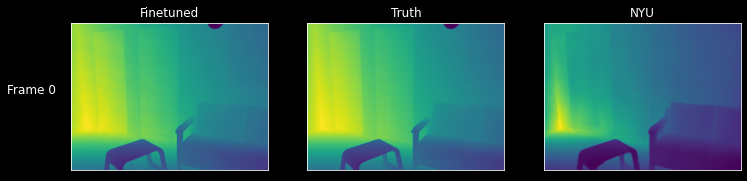

Frame 1 finetune err: {'absrel': 0.0038071870803833008, 'mae': 0.011462073773145676, 'delta1': 0.9999935030937195}
Frame 1 NYU err: {'absrel': 0.03341076150536537, 'mae': 0.10015111416578293, 'delta1': 0.9946939945220947}


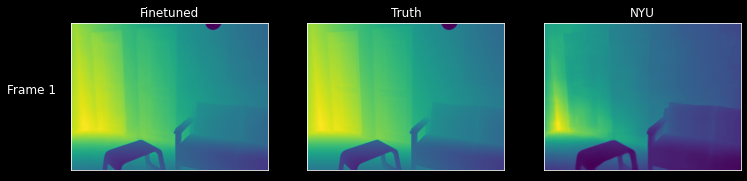

Frame 2 finetune err: {'absrel': 0.0035683943424373865, 'mae': 0.0107921427115798, 'delta1': 1.0}
Frame 2 NYU err: {'absrel': 0.03458153083920479, 'mae': 0.10298517346382141, 'delta1': 0.992968738079071}


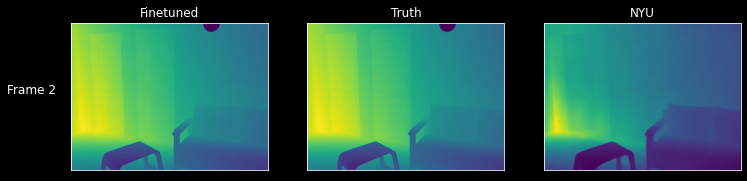

Frame 3 finetune err: {'absrel': 0.0036969527136534452, 'mae': 0.011192510835826397, 'delta1': 0.9999967217445374}
Frame 3 NYU err: {'absrel': 0.03511159494519234, 'mae': 0.10361024737358093, 'delta1': 0.9921907782554626}


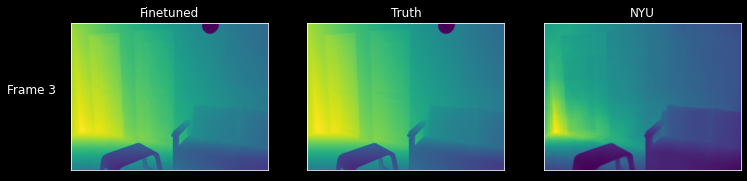

Frame 4 finetune err: {'absrel': 0.004035694058984518, 'mae': 0.01237589679658413, 'delta1': 0.9999902248382568}
Frame 4 NYU err: {'absrel': 0.036757178604602814, 'mae': 0.10729967802762985, 'delta1': 0.9916568994522095}


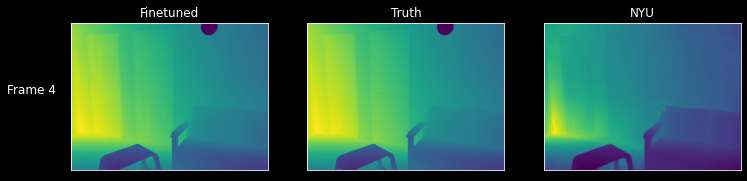

Frame 5 finetune err: {'absrel': 0.003873716341331601, 'mae': 0.01161611545830965, 'delta1': 0.9999479055404663}
Frame 5 NYU err: {'absrel': 0.03761807084083557, 'mae': 0.10857833921909332, 'delta1': 0.9907975196838379}


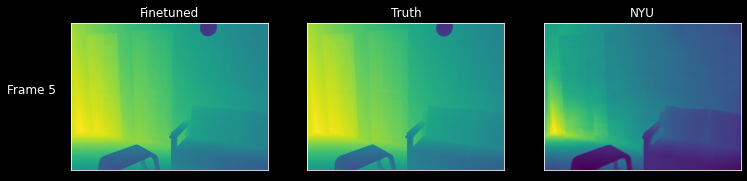

Frame 6 finetune err: {'absrel': 0.003924244549125433, 'mae': 0.011311306618154049, 'delta1': 0.9998828172683716}
Frame 6 NYU err: {'absrel': 0.04356410726904869, 'mae': 0.11706113815307617, 'delta1': 0.9871386885643005}


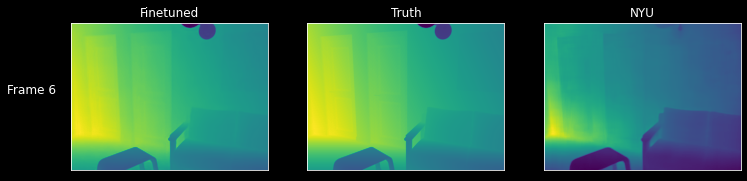

Frame 7 finetune err: {'absrel': 0.004528526682406664, 'mae': 0.012730402871966362, 'delta1': 0.9999544024467468}
Frame 7 NYU err: {'absrel': 0.053451187908649445, 'mae': 0.13057388365268707, 'delta1': 0.9816113114356995}


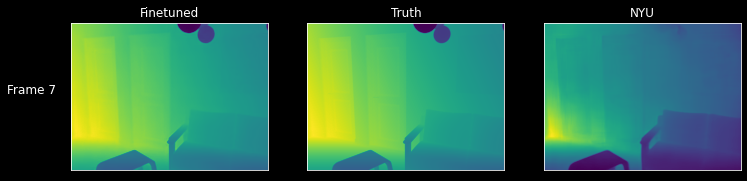

Frame 8 finetune err: {'absrel': 0.004597882740199566, 'mae': 0.012899456545710564, 'delta1': 0.9999186396598816}
Frame 8 NYU err: {'absrel': 0.061297133564949036, 'mae': 0.13733874261379242, 'delta1': 0.9756380319595337}


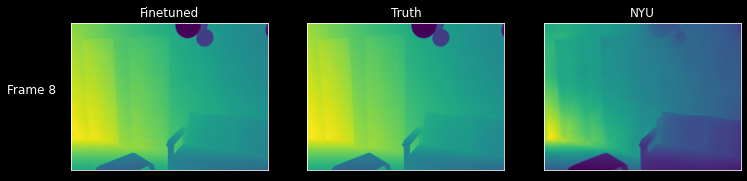

Frame 9 finetune err: {'absrel': 0.0045273867435753345, 'mae': 0.01275232620537281, 'delta1': 0.9998665452003479}
Frame 9 NYU err: {'absrel': 0.0699181854724884, 'mae': 0.1449904590845108, 'delta1': 0.9691308736801147}


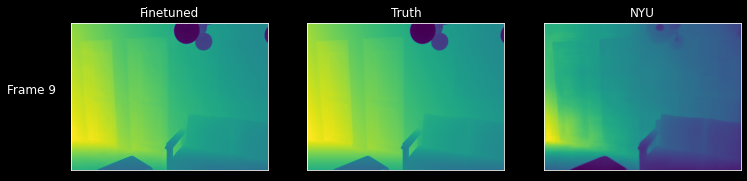

Frame 10 finetune err: {'absrel': 0.004557821899652481, 'mae': 0.012370007112622261, 'delta1': 0.9997721314430237}
Frame 10 NYU err: {'absrel': 0.07159209251403809, 'mae': 0.14326275885105133, 'delta1': 0.9647656083106995}


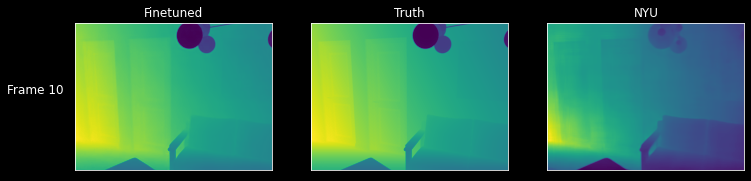

Frame 11 finetune err: {'absrel': 0.0051157595589756966, 'mae': 0.013758409768342972, 'delta1': 0.9993912577629089}
Frame 11 NYU err: {'absrel': 0.08035056293010712, 'mae': 0.1567952185869217, 'delta1': 0.9592512845993042}


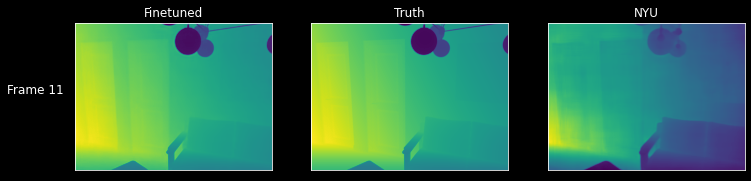

Frame 12 finetune err: {'absrel': 0.005422867368906736, 'mae': 0.013873657211661339, 'delta1': 0.999498724937439}
Frame 12 NYU err: {'absrel': 0.09995605796575546, 'mae': 0.18216125667095184, 'delta1': 0.9445703029632568}


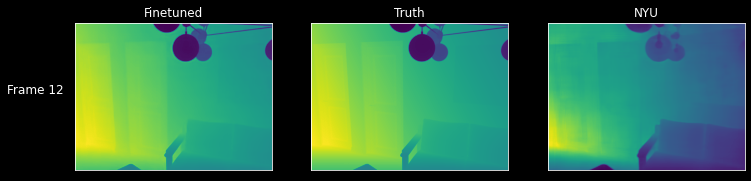

Frame 13 finetune err: {'absrel': 0.005812267307192087, 'mae': 0.014495360665023327, 'delta1': 0.9993814826011658}
Frame 13 NYU err: {'absrel': 0.12263898551464081, 'mae': 0.2107943743467331, 'delta1': 0.9268326759338379}


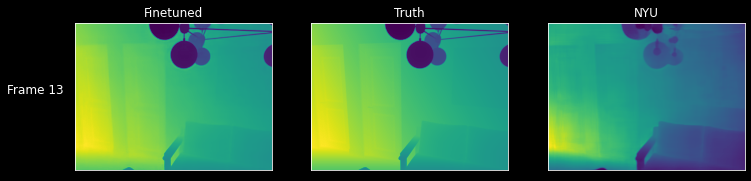

Frame 14 finetune err: {'absrel': 0.006438128650188446, 'mae': 0.015359396114945412, 'delta1': 0.9988899827003479}
Frame 14 NYU err: {'absrel': 0.14204949140548706, 'mae': 0.23862726986408234, 'delta1': 0.8670117259025574}


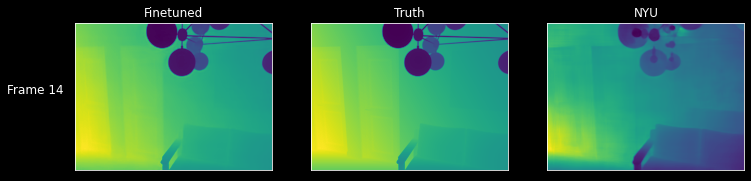

Frame 15 finetune err: {'absrel': 0.006742058787494898, 'mae': 0.015415535308420658, 'delta1': 0.9988997578620911}
Frame 15 NYU err: {'absrel': 0.16324135661125183, 'mae': 0.2665942311286926, 'delta1': 0.8295702934265137}


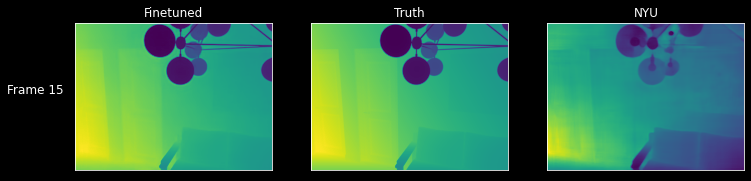

Frame 16 finetune err: {'absrel': 0.007042394485324621, 'mae': 0.015693293884396553, 'delta1': 0.999036431312561}
Frame 16 NYU err: {'absrel': 0.1850242018699646, 'mae': 0.2971324026584625, 'delta1': 0.8154720067977905}


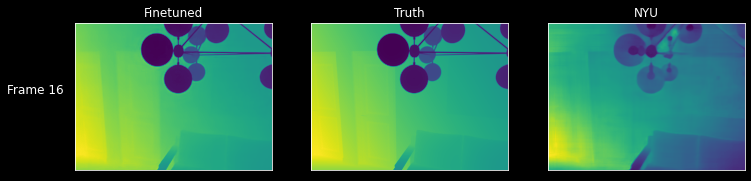

Frame 17 finetune err: {'absrel': 0.006776290014386177, 'mae': 0.014570897445082664, 'delta1': 0.9993196725845337}
Frame 17 NYU err: {'absrel': 0.200373113155365, 'mae': 0.32005929946899414, 'delta1': 0.7950455546379089}


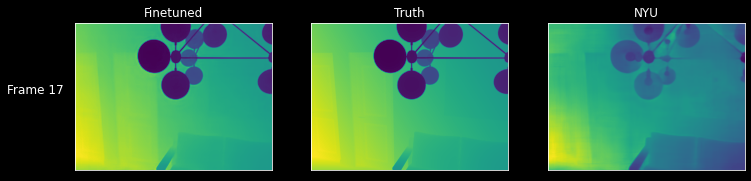

Frame 18 finetune err: {'absrel': 0.006470988038927317, 'mae': 0.01411487627774477, 'delta1': 0.9991113543510437}
Frame 18 NYU err: {'absrel': 0.19983457028865814, 'mae': 0.3161400556564331, 'delta1': 0.7924251556396484}


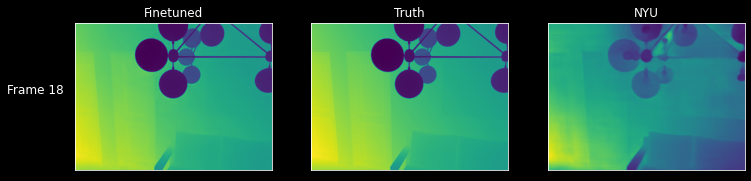

Frame 19 finetune err: {'absrel': 0.006482925731688738, 'mae': 0.014112422242760658, 'delta1': 0.9990494847297668}
Frame 19 NYU err: {'absrel': 0.19270531833171844, 'mae': 0.3079598546028137, 'delta1': 0.7848372459411621}


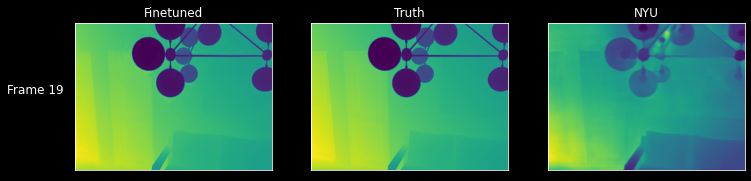

In [10]:
metric = DepthMetrics()

with torch.no_grad():
    num_photos = len(interiornet_dataset)
    for i,sample in enumerate(interiornet_dataset):
        fig = plt.figure(figsize=(12,12))
        
        image, depth = torch.tensor(sample['image']).to(device), torch.tensor(sample['depth']).to(device)
        out = model(image.unsqueeze(0))
        out_nyu = original_model(image.unsqueeze(0)).squeeze(0)
        # printed format is [absrel, mae, delta^1]
        print(f'Frame {i} finetune err:', metric(out, depth.unsqueeze(0)))
        print(f'Frame {i} NYU err:', metric(out_nyu, depth.unsqueeze(0)))
        
        out, depth, out_nyu = out.squeeze(0).to('cpu'), depth.to('cpu'), out_nyu.to('cpu')
        
        for j,img in enumerate([out, depth, out_nyu]):
            ax = fig.add_subplot(1,3,j+1)
            if j == 0:
                ax.set_ylabel(f'Frame {i}', rotation=0, size='large')
            ax.imshow(img)
            
            ax.yaxis.set_label_coords(-0.2, 0.5)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
        
        for ax,name in zip(fig.axes,['Finetuned', 'Truth', 'NYU']):
            ax.set_title(name)
                
        fig.show()
        
        if i >= num_photos - 1: break
        i += 1
        
        plt.show()